## Introduction

The dataset I will use for my experiments is a medium sized Dutch dataset containing news articles from various Dutch newspapers. Each article is labelled as being written in a partisan or neutral style.

The dataset was originally published at the following [url](https://github.com/dpgmedia/partisan-news2019). However not all files are available anymore (they didn't pay for the AWS storage bills??).

The dataset is still available as a [Kaggle Dataset](https://www.kaggle.com/datasets/rsmits/dpgmedia2019). Use the Kaggle Dataset to download the files if you require those.

The focus of this notebook is todo some brief EDA, some data pre-processing and to split the dataset into rather small Train and Validation dataset.

The size of the datasets is chosen with the idea in mind that finetuning of GPT-3.5 doesn't need many samples to learn a classification. And also to make sure that my credit card bill won't explode ;-)

The size is still acceptable to also train and validate some older Transformer models (Multi-lingual DistilBert and Bert). This allows us to make an interresting comparison between regular Transformer models and the latest available GPT-3.5 model. 

!! Note: At the time of writing I have not yet gained access to GPT-4...but when I do I will add it to this experiment.

In [1]:
# Import Modules
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# Constants
SEED = 42
MAX_WORDS = 192

Download the files as mentioned below from the Kaggle Dataset location and store them in a folder of your own choosing. Modify the code if necessary.

In [3]:
def get_dpgnews_df(seed):
    # Set 1: Articles
    articles_df = pd.read_json('./dpgMedia2019-articles-bypublisher.jsonl', lines = True)
    articles_df = articles_df.set_index('id')
    
    # Set 2: Labels
    labels_df = pd.read_json('./dpgMedia2019-labels-bypublisher.jsonl', lines = True)
    labels_df = labels_df.set_index('id')
    
    # Finalize Full Data
    dpgnews_df = articles_df.join(labels_df, on = ['id'], how = 'inner')
    
    # Randomize all rows...
    dpgnews_df = dpgnews_df.sample(frac = 1.0, random_state = seed)
    dpgnews_df.reset_index(inplace = True)
    print(f'DPGNews2019 Dataframe Shape: {dpgnews_df.shape}') 

    return dpgnews_df

# Get DpgNews Dataframe
dpgnews_df = get_dpgnews_df(SEED)

# summary
dpgnews_df.head()

DPGNews2019 Dataframe Shape: (103870, 8)


,id,title,text,mainSection,published_at,publisher,partisan,url
0,10971898,Ons oordeel over de mooiste en lelijkste kerst...,Ons oordeel over de mooiste en lelijkste kerst...,/algemeen,2018-12-25,eindhovensdagblad,false,www.ed.nl/show/ons-oordeel-over-de-mooiste-en-...
1,10976088,Alan Parsons Project speelt in april in Paradiso,Alan Parsons Project speelt in april in Paradi...,/nieuws,2018-12-06,parool,true,www.parool.nl/nieuws/alan-parsons-project-spee...
2,9359799,"'Geer, ga met je dikke kont van die struisvoge...","'Geer, ga met je dikke kont van die struisvoge...",/algemeen,2018-01-11,eindhovensdagblad,false,www.ed.nl/show/-geer-ga-met-je-dikke-kont-van-...
3,10237812,België onderzoekt video kindermishandeling,België onderzoekt video kindermishandelingDe B...,/nieuws,2018-07-22,ad,false,www.ad.nl/buitenland/belgie-onderzoekt-video-k...
4,7303393,Oud-medewerkers Turkse beurs opgepakt voor 'ba...,Oud-medewerkers Turkse beurs opgepakt voor 'ba...,/nieuws,2017-05-12,ad,false,www.ad.nl/buitenland/oud-medewerkers-turkse-be...


We can see some samples.

Looking at the value counts below for the partisan values we can see that the dataset is balanced enough to use for our binary classification experiment. 

In [4]:
# Partisan Label Count
dpgnews_df.partisan.value_counts()

partisan
true     52922
false    50948
Name: count, dtype: int64

Next we will plot a quick overview of the article count per newspaper publisher and the partisan label distribution.

[Text(0.5, 1.0, 'Article count per Publisher')]

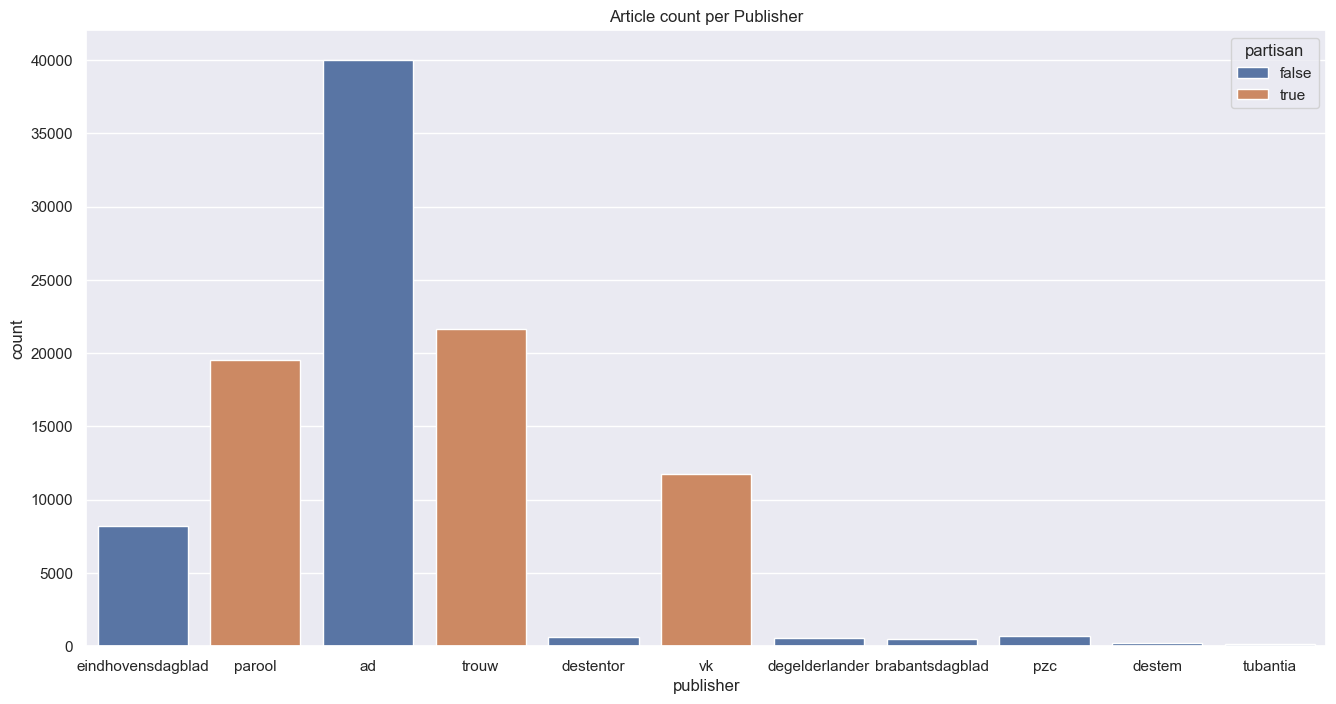

In [5]:
# Plot
sns.set(rc= {"figure.figsize": (16, 8)}) 
sns.countplot(x = 'publisher', data = dpgnews_df, hue = 'partisan').set(title = 'Article count per Publisher')

The word count in each article can differ a lot. Let's determine the word count per article and look at the distribution.

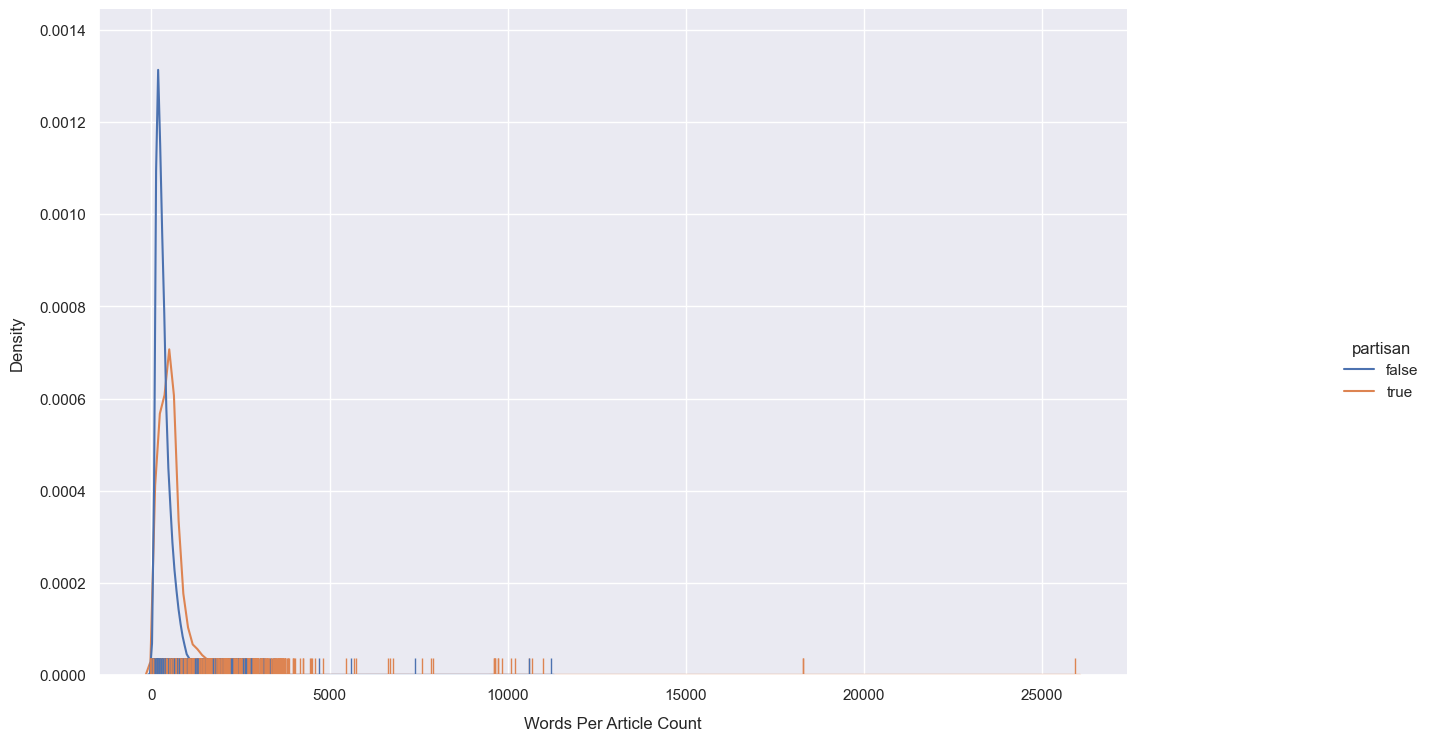

In [6]:
# Word count
dpgnews_df['text_wordcount'] = dpgnews_df.text.str.split(' ').str.len()

# Plot Words Count
g = sns.displot(dpgnews_df, kind = 'kde', rug = True, x = 'text_wordcount', hue = 'partisan')
g.set_axis_labels('Words Per Article Count', 'Density', labelpad = 10)
g.fig.set_size_inches(16, 8)

The majority of articles has a word count of a few hundred words with some outliers having a word count of 5000 or higher words.

To allow for easier comparison between GPT-3.5 and other Transformer models (which often have a limit of 512 input tokens) I will maximize each article at a maximum of 192 words.

Even with different tokenization methods the amount of tokenized text is the same that way.

In [7]:
# Maximize Text to number of words
def maximize_word_count(text):
    text_list = text.split(' ')
    
    if len(text_list) >= MAX_WORDS:
        maximized_text = ' '.join(text_list[:MAX_WORDS])
    else:
        maximized_text = ' '.join(text_list)
    return maximized_text

# Map
dpgnews_df['max_words_text'] =  dpgnews_df.apply(lambda x: maximize_word_count(x.text), axis = 1)   

# Summary
dpgnews_df.head()

,id,title,text,mainSection,published_at,publisher,partisan,url,text_wordcount,max_words_text
0,10971898,Ons oordeel over de mooiste en lelijkste kerst...,Ons oordeel over de mooiste en lelijkste kerst...,/algemeen,2018-12-25,eindhovensdagblad,false,www.ed.nl/show/ons-oordeel-over-de-mooiste-en-...,1691,Ons oordeel over de mooiste en lelijkste kerst...
1,10976088,Alan Parsons Project speelt in april in Paradiso,Alan Parsons Project speelt in april in Paradi...,/nieuws,2018-12-06,parool,true,www.parool.nl/nieuws/alan-parsons-project-spee...,157,Alan Parsons Project speelt in april in Paradi...
2,9359799,"'Geer, ga met je dikke kont van die struisvoge...","'Geer, ga met je dikke kont van die struisvoge...",/algemeen,2018-01-11,eindhovensdagblad,false,www.ed.nl/show/-geer-ga-met-je-dikke-kont-van-...,280,"'Geer, ga met je dikke kont van die struisvoge..."
3,10237812,België onderzoekt video kindermishandeling,België onderzoekt video kindermishandelingDe B...,/nieuws,2018-07-22,ad,false,www.ad.nl/buitenland/belgie-onderzoekt-video-k...,121,België onderzoekt video kindermishandelingDe B...
4,7303393,Oud-medewerkers Turkse beurs opgepakt voor 'ba...,Oud-medewerkers Turkse beurs opgepakt voor 'ba...,/nieuws,2017-05-12,ad,false,www.ad.nl/buitenland/oud-medewerkers-turkse-be...,107,Oud-medewerkers Turkse beurs opgepakt voor 'ba...


Next we will create binary labels and split the main dataset in smaller training and validation datasets.

The training and validation .csv files are stored in Github in case you would like to reproduce these experiments.

In [8]:
# Partisan Modify
labels = []

# Tokenize
for index, row in dpgnews_df.iterrows():
    partisan = row['partisan']
    labels.append(1 if partisan == 'true' else 0)
dpgnews_df["labels"] = labels

# Train Test Split
subset_df, val_df = train_test_split(dpgnews_df, 
                                    test_size = 0.015, 
                                    random_state = SEED,
                                    stratify = dpgnews_df.partisan.values)

# Train Test Split
train_df, _ = train_test_split(subset_df, 
                               test_size = 0.97, 
                               random_state = SEED,
                               stratify = subset_df.partisan.values)

# Summary
print(f'Training Dataset Shape: {train_df.shape}')
print(f'Validation Dataset Shape: {val_df.shape}')

# Save to Disk
train_df.to_csv('./data/train_df.csv', index = False)
val_df.to_csv('./data/val_df.csv', index = False)

Training Dataset Shape: (3069, 11)
Validation Dataset Shape: (1559, 11)


## Train Dataset 

In [9]:
# Value Counts
train_df.labels.value_counts()

labels
1    1564
0    1505
Name: count, dtype: int64

In [10]:
# Summary
train_df.head()

,id,title,text,mainSection,published_at,publisher,partisan,url,text_wordcount,max_words_text,labels
25432,10706318,Ogen als schoteltjes bij de Tachtigjarige Oorlog,Ogen als schoteltjes bij de Tachtigjarige Oorl...,/home,2018-10-07,trouw,true,www.trouw.nl/home/ogen-als-schoteltjes-bij-de-...,539,Ogen als schoteltjes bij de Tachtigjarige Oorl...,1
31592,12633805,"Geen beeld, maar een monument voor Mandela in ...","Geen beeld, maar een monument voor Mandela in ...",/amsterdam,2019-05-10,parool,true,www.parool.nl/amsterdam/geen-beeld-maar-een-mo...,662,"Geen beeld, maar een monument voor Mandela in ...",1
67378,7140125,Hoe ga je een onveilige arbeidscultuur zoals i...,Hoe ga je een onveilige arbeidscultuur zoals i...,/,2017-04-18,trouw,true,,494,Hoe ga je een onveilige arbeidscultuur zoals i...,1
102377,4490774,Wetenschappers ontdekken lichtgevende discokikker,Wetenschappers ontdekken lichtgevende discokik...,/,2017-03-14,trouw,true,,291,Wetenschappers ontdekken lichtgevende discokik...,1
78848,10592180,Meer fouten kabinet bij steun aan strijdgroepe...,Meer fouten kabinet bij steun aan strijdgroepe...,/home,2018-09-11,trouw,true,www.trouw.nl/home/meer-fouten-kabinet-bij-steu...,471,Meer fouten kabinet bij steun aan strijdgroepe...,1


[Text(0.5, 1.0, 'Training Dataset - Article count per Publisher')]

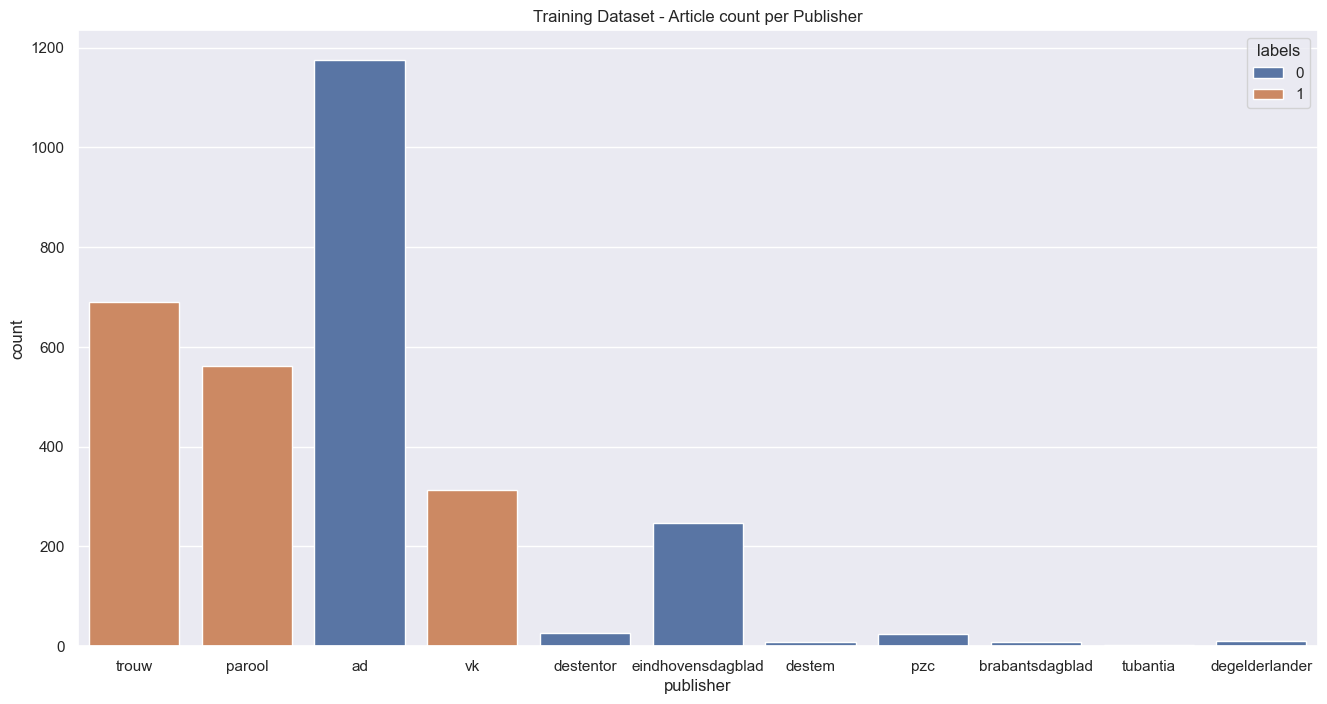

In [11]:
# Plot
sns.set(rc= {"figure.figsize": (16, 8)}) 
sns.countplot(x = 'publisher', data = train_df, hue = 'labels').set(title = 'Training Dataset - Article count per Publisher')

## Validation Dataset 

In [12]:
# Value Counts
val_df.labels.value_counts()

labels
1    794
0    765
Name: count, dtype: int64

In [13]:
# Summary
val_df.head()

,id,title,text,mainSection,published_at,publisher,partisan,url,text_wordcount,max_words_text,labels
24718,9266995,Verdachte dodelijke steekpartijen Maastricht l...,Verdachte dodelijke steekpartijen Maastricht l...,/nieuws,2017-12-18,ad,false,www.ad.nl/binnenland/verdachte-dodelijke-steek...,188,Verdachte dodelijke steekpartijen Maastricht l...,0
93241,4130077,Honderden arrestaties bij acties tegen mensen ...,Honderden arrestaties bij acties tegen mensen ...,/nieuws,2017-02-11,ad,false,www.ad.nl/buitenland/honderden-arrestaties-bij...,122,Honderden arrestaties bij acties tegen mensen ...,0
85956,11147268,Waarom de 'oudejaarsbonus' voor de jongeren va...,Waarom de 'oudejaarsbonus' voor de jongeren va...,/home,2019-01-20,trouw,true,www.trouw.nl/home/waarom-de-oudejaarsbonus-voo...,262,Waarom de 'oudejaarsbonus' voor de jongeren va...,1
65239,10749100,Klaar voor de verdediging,Klaar voor de verdedigingOver ruim een week be...,/nieuws,2018-10-16,ad,false,www.ad.nl/binnenland/klaar-voor-de-verdediging...,411,Klaar voor de verdedigingOver ruim een week be...,0
9132,10700707,Windvlaag grijpt springmatras en doodt 2-jarig...,Windvlaag grijpt springmatras en doodt 2-jarig...,/nieuws,2018-10-05,ad,false,www.ad.nl/buitenland/windvlaag-grijpt-springma...,286,Windvlaag grijpt springmatras en doodt 2-jarig...,0


[Text(0.5, 1.0, 'Validation Dataset - Article count per Publisher')]

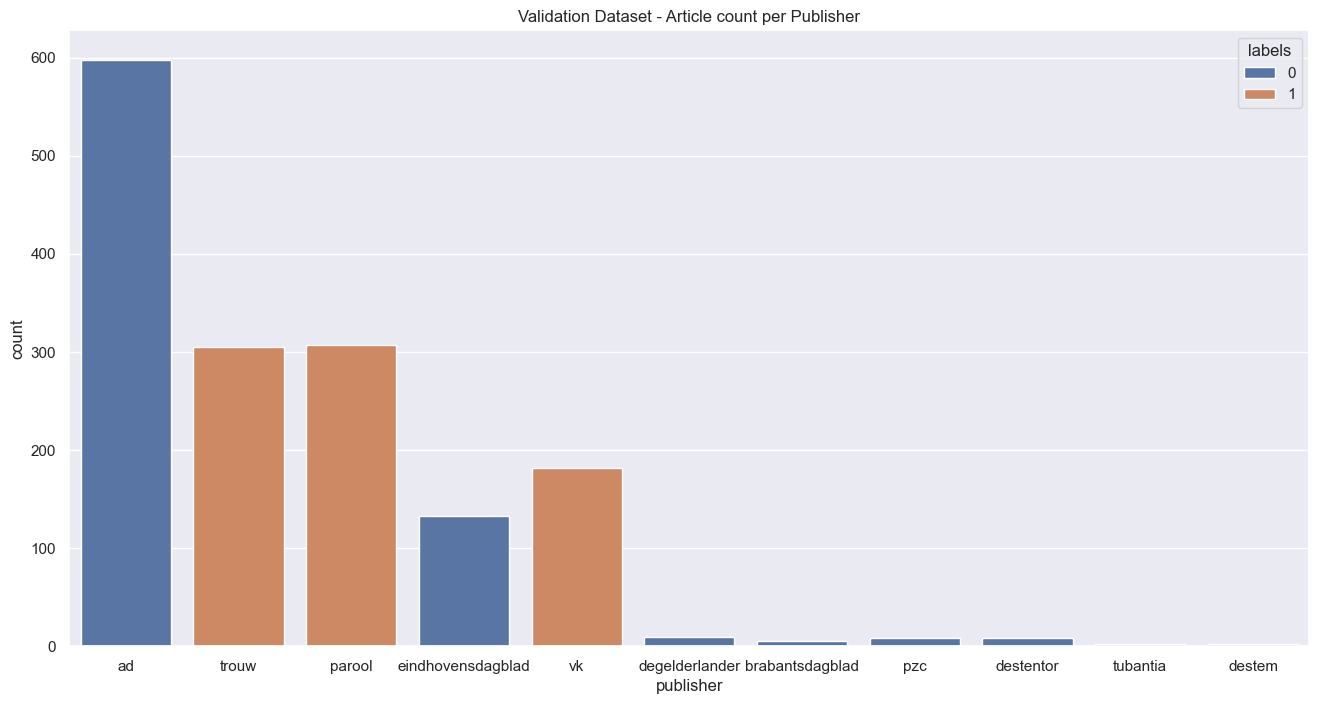

In [14]:
# Plot
sns.set(rc= {"figure.figsize": (16, 8)}) 
sns.countplot(x = 'publisher', data = val_df, hue = 'labels').set(title = 'Validation Dataset - Article count per Publisher')